# Intro

Some experiments to get a good score for the [Identify Age-Related Conditions][0] kaggle competition.

Start by importing commonly used modules that make it convenient to work with the fastai library. Some will be patched to make them work in non-standard ways but improve interactivity.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions

On kaggle, attach the `pip-packages-icr` dataset then uncomment the following to install tabpfn

In [1]:
#!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages
#!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
#!cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [2]:
from fastai.imports import *
from fastai.tabular.all import *

# Data Inspection

Get the dataset appropriately whether we're in kaggle or not. If in kaggle, it is assumed the competition dataset has been connected to the notebook.

In [3]:
import os
competition_name = "icr-identify-age-related-conditions"

is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    path = Path(f"/kaggle/input/{competition_name}")
else:
    import zipfile, kaggle
    path = Path.home() / '.kaggle' / 'input' / competition_name
    kaggle.api.competition_download_cli(competition_name, path=path.parent)
    zipfile.ZipFile(f'{path}.zip').extractall(path)

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)


Load the datasets. It's a small dataset so we can set the `low_memory` pandas flag to `False`.

In [4]:
path.ls()

(#4) [Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')]

In [5]:
df_train = pd.read_csv(f'{path}/train.csv', low_memory=False)
df_test = pd.read_csv(f'{path}/test.csv', low_memory=False)
greeks = pd.read_csv(f'{path}/greeks.csv', low_memory=False)

df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [6]:
df_train.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

We can now examine the data.

In [7]:
df_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


We see that the mean of the dependant column `Class` is much closer to zero than one. This means that the observations with a positive diagnosis are smaller in proportion in the training data. We confirm this by plotting a pie chart for column `Class`.

<Axes: ylabel='count'>

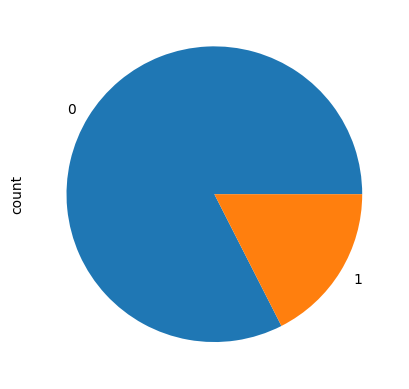

In [8]:
%matplotlib inline

df_train.Class.value_counts().plot.pie()

We also check for null values

In [9]:
df_nulls = df_train.isna().sum()
df_nulls[df_nulls > 0]

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

 # Data Processing
 
We'll do some simple processing. We'll replace the categorical columns `EJ` and `Id` with numeric codes representing their levels. We'll have two sets of train/test datasets, with nulls and without nulls. We'll also add in the date column `Epsilon` from greeks data.

In [11]:
from datetime import datetime

dates = greeks.Epsilon.copy()
dates = dates.map(lambda x: datetime.strptime(x, '%m/%d/%Y').toordinal() if x.lower() != "unknown" else np.nan)
max_date = dates.max()

In [12]:
df_train["Epsilon"] = dates
df_test["Epsilon"] = max_date + 1
df_train_na = df_train.copy()
df_test_na = df_test.copy()

modes = df_train.mode().iloc[0]
df_train.fillna(modes, inplace=True)
df_test.fillna(modes, inplace=True)

def process_data(df):
    df["EJ"] = pd.Categorical(df.EJ).codes
    df["Id"] = pd.Categorical(df.Id).codes


for df in [df_train, df_train_na, df_test, df_test_na]:
    process_data(df)

# Modelling

Because of the small dataset size, we'll use stratified K-fold for our train/test splits. 

The competition uses the balanced log loss metric which is explained more [here][0]. For our purposes, we'll use the simple implementation.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/422442

In [13]:
from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

def m_log_loss(model, xs, y): return balanced_log_loss(np.array(y), np.array(model.predict(xs)))

For each fold, we train and validate a model and collect the metrics. We use k-fold validation because of the small dataset size. Additionally, within each fold, we oversample the positive classification.

In [14]:
ycol = "Class"
xcols = [c for c in df_train.columns if not c in [ycol]]

def x_y(df):
    y = df[ycol]
    x = df[xcols]
    return x, y



In [15]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

def get_folds(k_fold, index, y):
    return [splits for splits in k_fold.split(index, y)]

def evaluate_model(m, df, train_ids, val_ids):
    train_xy, valid_xy = df.iloc[train_ids], df.iloc[val_ids]
    
    train_x, train_y = x_y(train_xy)
    val_x, val_y = x_y(valid_xy)
            
    m.fit(train_x, train_y) 
        
    preds = m.predict_proba(val_x)
    class1_preds = preds[:,1]
    logloss = balanced_log_loss(val_y, class1_preds)
   
    return m, logloss

In [16]:
class_counts = df_train.Class.value_counts()
class_counts

Class
0    509
1    108
Name: count, dtype: int64

In [17]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from tabpfn import TabPFNClassifier

s_kfold = StratifiedKFold(n_splits=5, shuffle=False)
#rs_kfold = RepeatedStratifiedKFold()

folds = get_folds(s_kfold, df_train.index, df_train.Class)

tabpfn_params = dict(device='cpu', N_ensemble_configurations=16) if not is_kaggle else dict(device='cuda:0', N_ensemble_configurations=64)
tabpfn = TabPFNClassifier(**tabpfn_params)

xgb_params = {'colsample_bytree': 0.8757972257439255, 'gamma': 0.11135738771999848, 'max_depth': 7, 'min_child_weight': 3, 'reg_alpha': 0.4833998914998038, 'reg_lambda': 0.006223568555619563, 'subsample': 0.7056434340275685}
xgb = XGBClassifier(eval_metric="logloss", scale_pos_weight=class_counts[0]/class_counts[1])#, **xgb_params)

#lgbm = LGBMClassifier(metric="binary_logloss", scale_pos_weight=class_counts[0]/class_counts[1], max_depth=9, num_leaves=15)
lgbm = LGBMClassifier(metric="binary_logloss", scale_pos_weight=class_counts[0]/class_counts[1])

hgb = HistGradientBoostingClassifier(class_weight="balanced")

kfold_params = [('xgb', xgb), ('hgb', hgb), ('tabpfn', tabpfn), ('lgbm', lgbm)]
kfold_results = {}
model_scores = []  # store a tuple of (score, fold, model)

for name, m in kfold_params:
    
    results = defaultdict(list)
    if name == "lgbm":
        kfold_df = df_train
    else:
        kfold_df = df_train_na
    
    for i, (x_split, y_split) in enumerate(folds):
        print(f"fold: {i}.. ", end="")
    
        model, logloss = evaluate_model(m, kfold_df, x_split, y_split)
        results['models'].append(model)
        results['loglosses'].append(logloss)
        
        model_scores.append((logloss, i, model))
    
    results['mean_logloss'] = np.mean(results['loglosses'])
    
    kfold_results[name] = results

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
fold: 0.. fold: 1.. fold: 2.. fold: 3.. fold: 4.. fold: 0.. fold: 1.. fold: 2.. fold: 3.. fold: 4.. fold: 0.. fold: 1.. fold: 2.. fold: 3.. fold: 4.. fold: 0.. [LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 86, number of negative: 407
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7607
[LightGBM] [Info] Number of data points in the train set: 493, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174442 -> initscore=-1.554466
[LightGBM] [Info] Start training from score -1.554466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

fold: 1.. [LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 86, number of negative: 407
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7534
[LightGBM] [Info] Number of data points in the train set: 493, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174442 -> initscore=-1.554466
[LightGBM] [Info] Start training from score -1.554466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [18]:
kfold_results

{'xgb': defaultdict(list,
             {'models': [XGBClassifier(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, early_stopping_rounds=None,
                             enable_categorical=False, eval_metric='logloss',
                             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
                             importance_type=None, interaction_constraints=None,
                             learning_rate=None, max_bin=None, max_cat_threshold=None,
                             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                             max_leaves=None, min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100, n_jobs=None,
                             num_parallel_tree=None, predictor=None, random_state=None, ...),
               XGBClassifier(base_score=N

Below is the overall mean prediction by the kfold ensembles

In [19]:
ensembles = ['xgb', 'hgb', 'tabpfn', 'lgbm']
all_loglosses = []
[all_loglosses.extend(kfold_results[k]['loglosses']) for k in ensembles]
np.mean(all_loglosses)

0.3606437534756314

We can order the models by their logloss score. For example, the top 7 performing models across all the folds are:

In [20]:
import heapq

top_7 = heapq.nsmallest(7, model_scores)
top_7

[(0.16884874161089844,
  0,
  HistGradientBoostingClassifier(class_weight='balanced')),
 (0.20949130232372967,
  0,
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='logloss',
                feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=None, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, predictor=None, random_state=None, ...)),
 (0.24007419633469843, 1, TabPFNClassifier(N_ensemble_configurations=16)),
 (0.26120641734066374,
  4,


Looks like fold 2 doesn't produce any top 7 models. We can cross-validate the top 7 models across all the samples to see which give the best average score.

In [21]:
top_models = [m for _, _, m in top_7]
top_models

top_scores, top_2_scores, top_3_scores, top_4_scores, top_5_scores, top_6_scores, top_7_scores = [], [], [], [], [], [], []

for x_split, y_split in folds:    
    
    for i, m in enumerate(top_models):
        if 'TabPFNClassifier' in str(type(m)):
            val_df = df_train.iloc[y_split]
        else:
            val_df = df_train_na.iloc[y_split]
        
        X, y = x_y(val_df)
        preds = m.predict_proba(X)
        class1_preds = preds[:,1]
        logloss = balanced_log_loss(y, class1_preds)
        
        # append to appropriate results lists
        if i == 0:
            top_scores.append(logloss)
        if i <= 1:
            top_2_scores.append(logloss)
        if i <= 2:
            top_3_scores.append(logloss)
        if i <= 3:
            top_4_scores.append(logloss)
        if i <= 4:
            top_5_scores.append(logloss)
        if i <= 5:
            top_6_scores.append(logloss)
        top_7_scores.append(logloss)
      

In [22]:
top_7_scores

[0.0014148460733463659,
 0.0030775070132614837,
 0.05328321905207482,
 0.0014148460733463659,
 0.0030775070132614837,
 0.0014148460733463659,
 0.05328321905207482,
 0.0015307941000739203,
 0.0037892437853112777,
 0.04938992949818645,
 0.0015307941000739203,
 0.0037892437853112777,
 0.0015307941000739203,
 0.04938992949818645,
 0.0014106921216495598,
 0.003693372698416881,
 0.059689843803636435,
 0.0014106921216495598,
 0.003693372698416881,
 0.0014106921216495598,
 0.059689843803636435,
 0.0017017442638975616,
 0.0035331665255165317,
 0.05651543133104301,
 0.0017017442638975616,
 0.0035331665255165317,
 0.0017017442638975616,
 0.05651543133104301,
 0.26120641734066374,
 0.2766280996794353,
 0.45617808840458196,
 0.26120641734066374,
 0.2766280996794353,
 0.26120641734066374,
 0.45617808840458196]

Looks like the last sample was the hardest one for all the selected models to predict.

In [23]:
score_collections = [top_scores, top_2_scores, top_3_scores, top_4_scores, top_5_scores, top_6_scores, top_7_scores]
all_avg_scores = [np.mean(scores) for scores in score_collections]
all_avg_scores

[0.053452898779926226,
 0.05579858836015726,
 0.08220282637940635,
 0.07501534447953633,
 0.07164113117170672,
 0.06860975910640996,
 0.07809569386519491]

This [discussion][9] mentions a particular observation that is particularly hard to predict, Id `cf5439add02c`. We can observe what our top models predict for this one.

[9]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/430475

In [24]:
df_train_raw = pd.read_csv(f'{path}/train.csv', low_memory=False)
row = df_train_raw[df_train_raw.Id == "cf5439add02c"]
row

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
509,cf5439add02c,0.132463,1777.81186,85.200147,18.591291,8.138688,4.544667,0.11571,9.856328,8.531992,...,0.173229,2.03464,0.088049,17.320324,146.586979,12008.3796,29.116825,21.291016,21.978,1


In [25]:
row_idx = 509
row_preds = []
for m in top_models:
    if 'TabPFNClassifier' in str(type(m)):
        df = df_train
    else:
        df = df_train_na
    row_df = df.filter(items=[row_idx], axis=0)
    row_preds.append(m.predict_proba(row_df[xcols])[0])

row_preds

[array([9.99634295e-01, 3.65704707e-04]),
 array([9.9968898e-01, 3.1100193e-04], dtype=float32),
 array([9.999666e-01, 3.332492e-05], dtype=float32),
 array([9.99634295e-01, 3.65704707e-04]),
 array([9.9968898e-01, 3.1100193e-04], dtype=float32),
 array([9.99634295e-01, 3.65704707e-04]),
 array([9.999666e-01, 3.332492e-05], dtype=float32)]

Looks problematic here as well.


# Submission

We'll get predictions from the ensemble by averaging all the predictions from the individual models. It's possible that the top model alone could be overfitting. So we'll submit predictions from an ensemble of the top 6 models. This will balance both the score, and the available model types.


In [26]:
top_6_models = top_models[:6]
top_6_models

[HistGradientBoostingClassifier(class_weight='balanced'),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None, ...),
 TabPFNClassifier(N_ensemble_configurations=16),
 HistGradientBoostingClassifier(class_weight='balanced'),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
    

In [27]:
final_preds = []

for m in top_6_models:
    if 'TabPFNClassifier' in str(type(m)):
        t_df = df_test
    else:
        t_df = df_test_na
    
    final_preds.append(m.predict_proba(t_df[xcols]))


print(f'total preds: {len(final_preds)}')
avg_preds = np.stack(final_preds).mean(axis=0)
avg_preds

total preds: 6


array([[0.93422571, 0.06577427],
       [0.934226  , 0.06577401],
       [0.93422593, 0.06577406],
       [0.93422557, 0.06577443],
       [0.93422554, 0.06577445]])

In [28]:
submit=False
if is_kaggle and submit:

    df_submission = pd.read_csv(f"{path}/sample_submission.csv")
    df_submission[["class_0", "class_1"]] = avg_preds
    df_submission.to_csv("submission.csv", index=False)